In [1]:
import pandas as pd
import pandas.rpy.common as com
%load_ext rpy2.ipython

In [47]:
%%R
library(ggplot2)
library(dplyr); library(tidyr)
library(RColorBrewer)
library(zoo)


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [3]:
!head /home/ashley/priming_exp/data/respiration/gas_data.csv

Time.hours,Time.days,Treatment,Flask,CO2.ppm,m.z
41.0,1.7083333330000001,12C100,1,211.65097000000003,44
114.0,4.75,12C100,1,110.17706000000001,44
157.5,6.5625,12C100,1,190.95872,44
204.5,8.520833332999999,12C100,1,312.53505,44
274.5,11.4375,12C100,1,1374.76475,44
321.5,13.39583333,12C100,1,930.4757199999999,44
391.0,16.29166667,12C100,1,1717.2775199999999,44
463.5,19.3125,12C100,1,1432.4708,44
487.0,20.29166667,12C100,1,360.5696,44


##ppm to mg total
###230 mL
###MW CO<sub>2</sub> as C: 12 g mol<sup>-1</sup>

In [4]:
def ppm2mgC(ppm):
    #ppm * dilution 
    return ppm * 9 / 1e6 / 22.4 / 1000 * 230 * 12 * 1000

In [5]:
df_gas = pd.read_csv("/home/ashley/priming_exp/data/respiration/gas_data.csv")
df_gas["CO2.mgC"] = df_gas["CO2.ppm"].apply(ppm2mgC)
df_gas.head()

,Time.hours,Time.days,Treatment,Flask,CO2.ppm,m.z,CO2.mgC
0,41.0,1.708333,12C100,1,211.65097,44,0.234706
1,114.0,4.750000,12C100,1,110.17706,44,0.122178
2,157.5,6.562500,12C100,1,190.95872,44,0.211760
3,204.5,8.520833,12C100,1,312.53505,44,0.346579
4,274.5,11.437500,12C100,1,1374.76475,44,1.524516


In [6]:
rdf_gas = com.convert_to_r_dataframe(df_gas, strings_as_factors=True)
%Rpush rdf_gas

In [7]:
%%R
head(rdf_gas)

  Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC
0       41.0  1.708333    12C100     1  211.6510  44 0.2347058
1      114.0  4.750000    12C100     1  110.1771  44 0.1221785
2      157.5  6.562500    12C100     1  190.9587  44 0.2117596
3      204.5  8.520833    12C100     1  312.5351  44 0.3465790
4      274.5 11.437500    12C100     1 1374.7648  44 1.5245159
5      321.5 13.395833    12C100     1  930.4757  44 1.0318311


In [8]:
%%R
#Negative values are generating incorrect values in analysis.  So I'm masking negative values by making them NA
rdf_gas$CO2.mgC[rdf_gas$CO2.mgC < 0] = NA

head(rdf_gas)

  Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC
0       41.0  1.708333    12C100     1  211.6510  44 0.2347058
1      114.0  4.750000    12C100     1  110.1771  44 0.1221785
2      157.5  6.562500    12C100     1  190.9587  44 0.2117596
3      204.5  8.520833    12C100     1  312.5351  44 0.3465790
4      274.5 11.437500    12C100     1 1374.7648  44 1.5245159
5      321.5 13.395833    12C100     1  930.4757  44 1.0318311


In [77]:
%%R
d = rdf_gas %>%
    filter(Flask != 35) %>%
    group_by(Flask, m.z, Treatment) %>%
    arrange(Time.hours) %>%
    mutate(CO2.mgC.cum = cumsum(na.approx(CO2.mgC, rule=2)))
d

Source: local data frame [2,244 x 8]
Groups: Flask, m.z, Treatment

   Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC CO2.mgC.cum
1        41.0  1.708333    12C100     1  211.6510  44 0.2347058   0.2347058
2       114.0  4.750000    12C100     1  110.1771  44 0.1221785   0.3568843
3       157.5  6.562500    12C100     1  190.9587  44 0.2117596   0.5686439
4       204.5  8.520833    12C100     1  312.5351  44 0.3465790   0.9152229
5       274.5 11.437500    12C100     1 1374.7648  44 1.5245159   2.4397388
6       321.5 13.395833    12C100     1  930.4757  44 1.0318311   3.4715699
7       391.0 16.291667    12C100     1 1717.2775  44 1.9043381   5.3759081
8       463.5 19.312500    12C100     1 1432.4708  44 1.5885078   6.9644159
9       487.0 20.291667    12C100     1  360.5696  44 0.3998459   7.3642618
10      535.0 22.291667    12C100     1  885.9140  44 0.9824153   8.3466771
..        ...       ...       ...   ...       ... ...       ...         ...


In [10]:
%%R
write.table(d, 
            file = "data/gas_cumltv_sum.csv",
            row.names = FALSE,
            sep = ",")

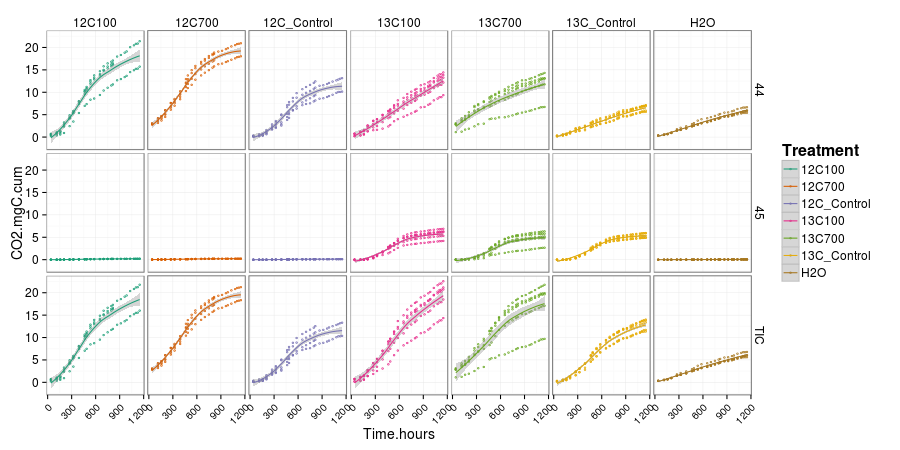

In [78]:
%%R -w 900 -h 450

p = ggplot(d, aes(x = Time.hours, y = CO2.mgC.cum, group = Flask, color = Treatment))

p = p  + facet_grid(m.z ~ Treatment)

p = p + geom_point(size = 0.75, shape = 21)

p = p + stat_smooth(method = "loess", aes(group = 1))

p = p + theme_bw()

p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12),
              axis.text.y = element_text(size = 12), 
              axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 16),
              legend.text = element_text(size = 12))

p = p + scale_color_brewer(palette="Dark2")

p

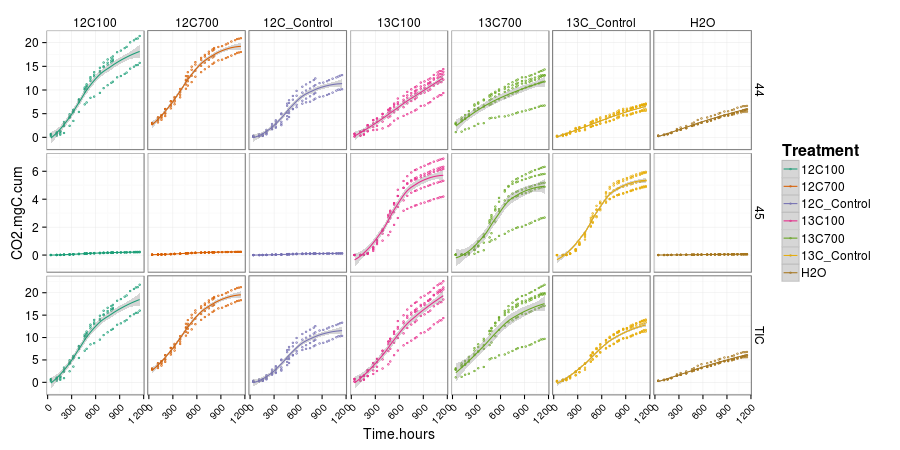

In [80]:
%%R -w 900 -h 450

p = ggplot(d, aes(x = Time.hours, y = CO2.mgC.cum, group = Flask, color = Treatment))

p = p  + facet_grid(m.z ~ Treatment, scales = "free_y")

p = p + geom_point(size = 0.75, shape = 21)

p = p + stat_smooth(method = "loess", aes(group = 1))

p = p + theme_bw()

p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12),
              axis.text.y = element_text(size = 12), 
              axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 16),
              legend.text = element_text(size = 12))

p = p + scale_color_brewer(palette="Dark2")

p

In [12]:
%%R
head(rdf_gas)

  Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC
0       41.0  1.708333    12C100     1  211.6510  44 0.2347058
1      114.0  4.750000    12C100     1  110.1771  44 0.1221785
2      157.5  6.562500    12C100     1  190.9587  44 0.2117596
3      204.5  8.520833    12C100     1  312.5351  44 0.3465790
4      274.5 11.437500    12C100     1 1374.7648  44 1.5245159
5      321.5 13.395833    12C100     1  930.4757  44 1.0318311


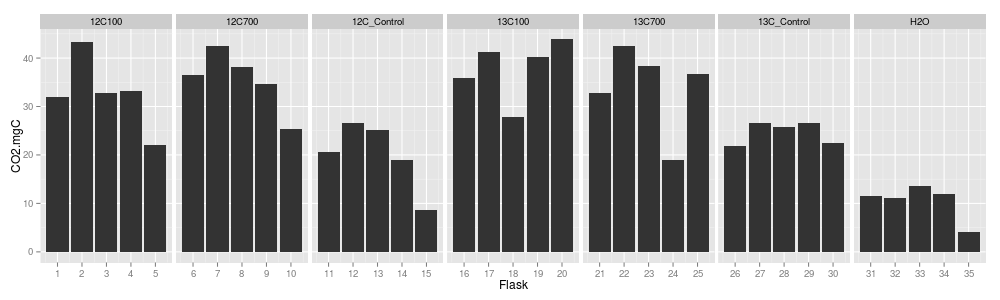

In [13]:
%%R -w 1000 -h 300
p = ggplot(rdf_gas, aes(x = Flask, y = CO2.mgC))

p = p + facet_wrap(~Treatment, scales = "free_x", nrow = 1)
p = p + geom_bar(stat = "identity")

p

In [14]:
%%R
d2 = rdf_gas %>%
    na.omit() %>%
    group_by(Flask, m.z, Treatment) %>%
    summarize(S = sum(CO2.mgC))
d2

Source: local data frame [104 x 4]
Groups: Flask, m.z

   Flask m.z Treatment          S
1      1  44    12C100 15.7280489
2      1  45    12C100  0.2012823
3      1 TIC    12C100 16.0072902
4      2  44    12C100 21.4041047
5      2  45    12C100  0.2278598
6      2 TIC    12C100 21.7899434
7      3  44    12C100 16.1687013
8      3  45    12C100  0.1690115
9      3 TIC    12C100 16.3637460
10     4  44    12C100 16.4545049
..   ... ...       ...        ...


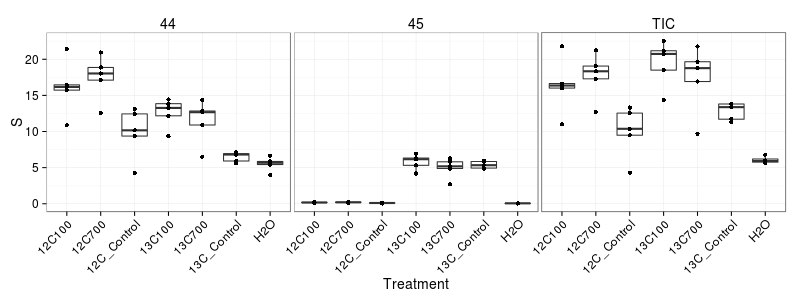

In [15]:
%%R -w 800 -h 300

p = ggplot(d2, aes(x = Treatment, y = S))

p = p + facet_wrap(~m.z)

p = p + geom_boxplot()

p = p + geom_point()

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
              axis.text.y = element_text(size = 12), 
              axis.title = element_text(size = 14),
              strip.background = element_blank(), 
              strip.text = element_text(size = 14))

p

In [32]:
%%R
print(d)

Source: local data frame [2,319 x 8]
Groups: Flask, m.z, Treatment

   Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC CO2.mgC.cum
1        41.0  1.708333    12C100     1  211.6510  44 0.2347058   0.2347058
2       114.0  4.750000    12C100     1  110.1771  44 0.1221785   0.3568843
3       157.5  6.562500    12C100     1  190.9587  44 0.2117596   0.5686439
4       204.5  8.520833    12C100     1  312.5351  44 0.3465790   0.9152229
5       274.5 11.437500    12C100     1 1374.7648  44 1.5245159   2.4397388
6       321.5 13.395833    12C100     1  930.4757  44 1.0318311   3.4715699
7       391.0 16.291667    12C100     1 1717.2775  44 1.9043381   5.3759081
8       463.5 19.312500    12C100     1 1432.4708  44 1.5885078   6.9644159
9       487.0 20.291667    12C100     1  360.5696  44 0.3998459   7.3642618
10      535.0 22.291667    12C100     1  885.9140  44 0.9824153   8.3466771
..        ...       ...       ...   ...       ... ...       ...         ...


In [16]:
%%R
d.ave = d %>%
    na.omit() %>%
    group_by(Time.hours, Treatment, m.z) %>%
    summarize(CO2.mgC.cum.ave = mean(CO2.mgC.cum), CO2.mgC.cum.sd = sd(CO2.mgC.cum))

print(d.ave)

Source: local data frame [523 x 5]
Groups: Time.hours, Treatment

   Time.hours   Treatment m.z CO2.mgC.cum.ave CO2.mgC.cum.sd
1          41      12C100  44     0.520609322    0.205312457
2          41      12C100  45     0.005390566    0.002133048
3          41      12C100 TIC     0.526154233    0.204680103
4          41      12C700  44     2.943999992    0.115226608
5          41      12C700  45     0.030323479    0.001182583
6          41      12C700 TIC     2.972753244    0.114840682
7          41 12C_Control  44     0.196428792    0.100252196
8          41 12C_Control  45     0.002051655    0.001063752
9          41 12C_Control TIC     0.198233637    0.099497430
10         41      13C100  44     0.530675319    0.297432063
..        ...         ... ...             ...            ...


In [38]:
%%R
#Select for Time til 50% of 13C-cellulose used for each flask/treatment
d.50pct = d %>%
    filter((m.z == "45") & (CO2.mgC.cum < 4.5)) %>%
    summarize(Time = max(Time.hours)) %>%
    filter(Treatment %in% c("13C100", "13C_Control", "13C700"))
d.50pct

Source: local data frame [15 x 4]
Groups: Flask, m.z

   Flask m.z   Treatment    Time
1     16  45      13C100  749.75
2     17  45      13C100  581.50
3     18  45      13C100 1150.00
4     19  45      13C100  581.50
5     20  45      13C100  535.00
6     21  45      13C700  915.25
7     22  45      13C700  581.50
8     23  45      13C700  581.50
9     24  45      13C700 1150.00
10    25  45      13C700  749.75
11    26  45 13C_Control  915.25
12    27  45 13C_Control  653.25
13    28  45 13C_Control  699.75
14    29  45 13C_Control  581.50
15    30  45 13C_Control  868.25


In [42]:
%%R
fit = lm(Time~Treatment, data = d.50pct)
#aov(Time~Treatment, data = d.50pct)
summary(fit)


Call:
lm(formula = Time ~ Treatment, data = d.50pct)

Residuals:
    Min      1Q  Median      3Q     Max 
-214.10 -150.07  -45.85  122.15  430.45 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            719.55      97.76   7.360 8.73e-06 ***
Treatment13C700         76.05     138.25   0.550    0.592    
Treatment13C_Control    24.05     138.25   0.174    0.865    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 218.6 on 12 degrees of freedom
Multiple R-squared:  0.02567,	Adjusted R-squared:  -0.1367 
F-statistic: 0.1581 on 2 and 12 DF,  p-value: 0.8555



In [45]:
%%R
anova(fit)

Analysis of Variance Table

Response: Time
          Df Sum Sq Mean Sq F value Pr(>F)
Treatment  2  15110    7555  0.1581 0.8555
Residuals 12 573433   47786               


In [35]:
%%R
c = subset(d.ave, (Time.hours == "1150") & (m.z == "45"))
print(c)

Source: local data frame [6 x 5]
Groups: Time.hours, Treatment

  Time.hours   Treatment m.z CO2.mgC.cum.ave CO2.mgC.cum.sd
1       1150      12C100  45       0.2012823             NA
2       1150      12C700  45       0.2317662    0.001236512
3       1150 12C_Control  45       0.1351995             NA
4       1150      13C100  45       5.7795201    1.054432608
5       1150      13C700  45       4.9760661    1.394910433
6       1150 13C_Control  45       5.4148832    0.514798166


Error : Mapping a variable to y and also using stat="bin".
  With stat="bin", it will attempt to set the y value to the count of cases in each group.
  This can result in unexpected behavior and will not be allowed in a future version of ggplot2.
  If you want y to represent counts of cases, use stat="bin" and don't map a variable to y.
  If you want y to represent values in the data, use stat="identity".
  See ?geom_bar for examples. (Defunct; last used in version 0.9.2)
In addition: There were 28 warnings (use warnings() to see them)


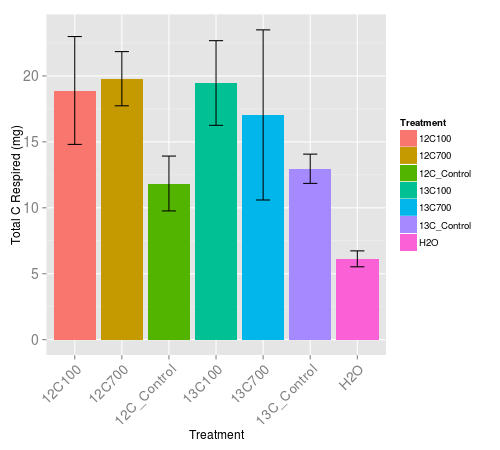

In [36]:
%%R -w 500 -h 450
c = subset(d.ave, (Time.hours == "1150") & (m.z == "TIC"))
limits <- aes(ymax = CO2.mgC.cum.ave + CO2.mgC.cum.sd, ymin= CO2.mgC.cum.ave - CO2.mgC.cum.sd)

p2 = ggplot(c, aes(x = Treatment, y = CO2.mgC.cum.ave, fill=Treatment))

p2 = p2 + geom_bar(stat="identity")

p2 = p2 + labs(x = "Treatment", y = "Total C Respired (mg)")

p2 = p2 + theme(axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
              axis.text.y = element_text(size = 14))

dodge <- position_dodge(width=0.9)
p2 = p2 + geom_bar(position=dodge) + geom_errorbar(limits, position=dodge, width=0.3)

p2